In [ ]:
import os
import glob
import random
import torch
import itertools
import datetime
import time
import sys
import argparse
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
from torchvision.utils import save_image, make_grid

什么是CycleGAN 

        CycleGAN是实现不同图像之间风格的转换，并且样本数据无需配对即可实现转换。
        CycleGAN的创新点在于能够在源域和目标域之间，无须建立训练数据间一对一的映射，就可以实现这种迁移。 
        CycleGAN特点：
            CycleGAN特点就是通过一个循环，首先将图像从一个域转换到另一个域，然后，再转回来，如果两次转换都很精准的话，那么，转换后的图像应该与输入的图像基本一致。通过这样的的一个循环，CycleGAN将转换前后图片的配对，类似于有监督学习，提升了转换效果。


CycleGAN的应用场景 

            CycleGAN主要用于Domain Adaption（域迁移）领域，如image style transfer图片风格迁移，物体转换，季节转化，图像增强领域取得了不错的效果。


CycleGAN原理

cycleGAN是一种由Generative Adversarial Networks发展而来的一种无监督机器学习，是在pix2pix的基础上发展起来的，主要应用于非配对图片的图像生成和转换，可以实现风格的转换，比如把照片转换为油画风格，或者把照片的橘子转换为苹果、马与斑马之间的转换等。因为不需要成对的数据集就能够转换，所以在数据准备上会简单很多，十分具有应用前景。

CycleGAN本质上是两个镜像对称的GAN，构成了一个环形网络。两个GAN共享两个生成器，并各自带一个判别器，即共有两个判别器和两个生成器。一个单向GAN两个loss，两个即共四个loss。


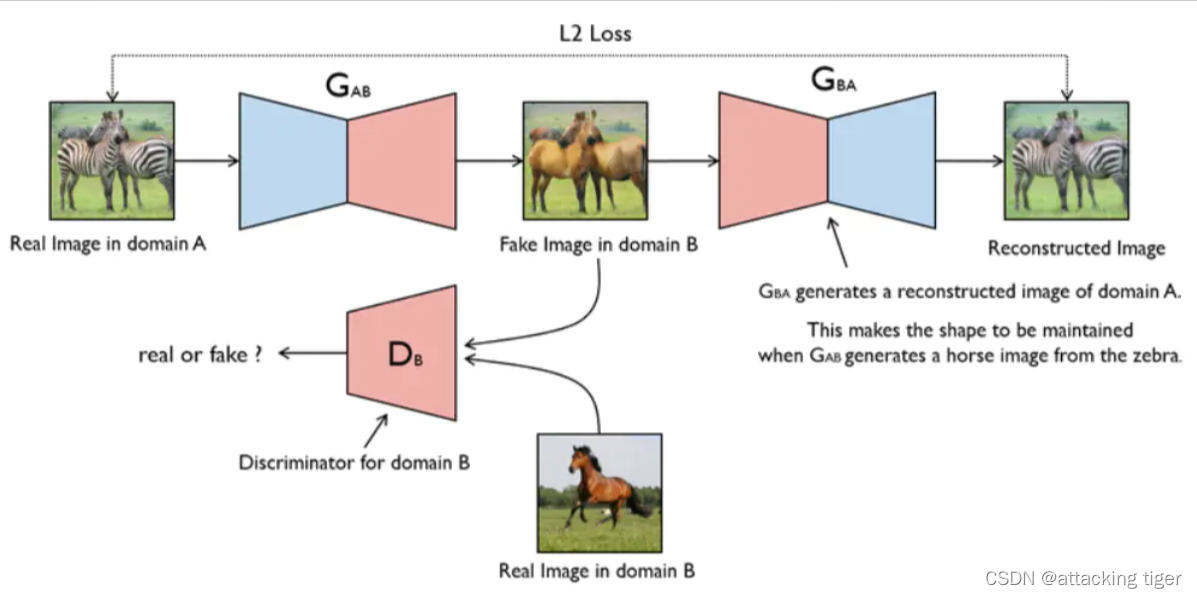

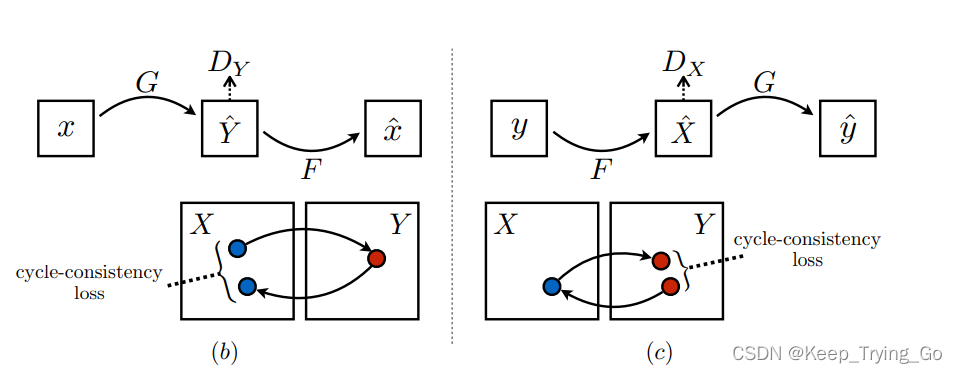

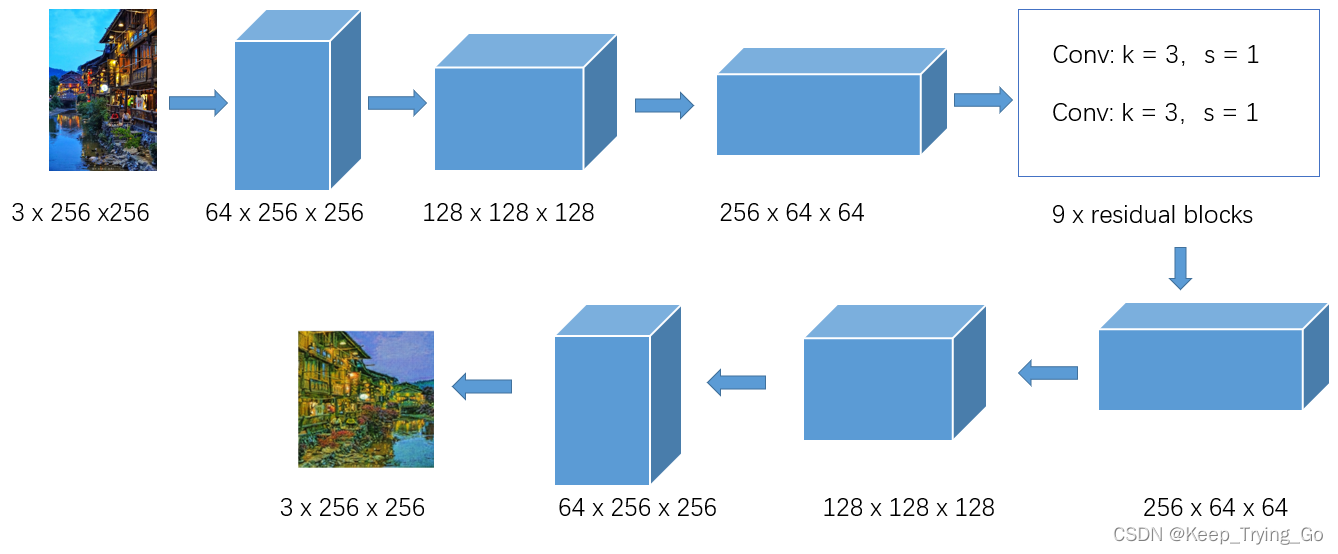

在CycleGAN的原论文中提到，对于生成器，如果输入的图像分辨率为:128 X 128大小的，则在网络中使用6个residual blocks；如果输入的图像分辨率为:256 x 256大小或者更大的，则在网络中使用9个residual blocks。

反射填充

这种填充方式是以输入向量的边界为对称轴，以设定的padding大小为步长，将输入向量的边界内padding大小的元素，对称填充。设定padding时主要注意，padding必须小于向量所在维度的大小。

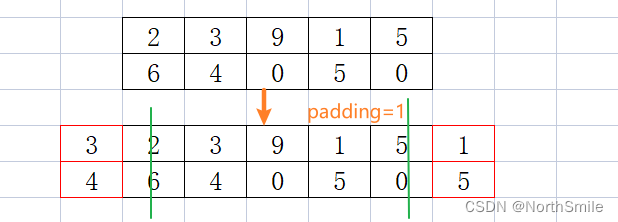

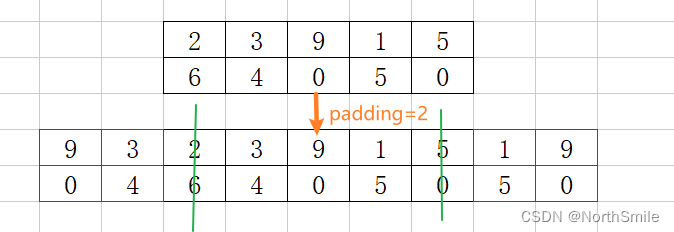

In [ ]:
#########################################################################
############################  datasets.py  ###################################

## 如果输入的数据集是灰度图像，将图片转化为rgb图像(本次采用的facades不需要这个)
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

## 构建数据集
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):          ## (root = "./datasets/facades", unaligned=True:非对其数据)
        self.transform = transforms.Compose(transforms_)                                ## transform变为tensor数据
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, "%sA" % mode) + "/*.*"))     ## "./datasets/facades/trainA/*.*"
        self.files_B = sorted(glob.glob(os.path.join(root, "%sB" % mode) + "/*.*"))     ## "./datasets/facades/trainB/*.*"

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])                   ## 在A中取一张照片

        if self.unaligned:                                                              ## 如果采用非配对数据，在B中随机取一张
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # 如果是灰度图，把灰度图转换为RGB图
        if image_A.mode != "RGB":
            image_A = to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = to_rgb(image_B)
        
        # 把RGB图像转换为tensor图, 方便计算，返回字典数据
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {"A": item_A, "B": item_B}

    ## 获取A,B数据的长度
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))



#########################################################################
############################  models.py  ###################################

## 定义参数初始化函数
def weights_init_normal(m):                                    
    classname = m.__class__.__name__                        ## m作为一个形参，原则上可以传递很多的内容, 为了实现多实参传递，每一个moudle要给出自己的name. 所以这句话就是返回m的名字. 
    if classname.find("Conv") != -1:                        ## find():实现查找classname中是否含有Conv字符，没有返回-1；有返回0.
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)     ## m.weight.data表示需要初始化的权重。nn.init.normal_():表示随机初始化采用正态分布，均值为0，标准差为0.02.
        if hasattr(m, "bias") and m.bias is not None:       ## hasattr():用于判断m是否包含对应的属性bias, 以及bias属性是否不为空.
            torch.nn.init.constant_(m.bias.data, 0.0)       ## nn.init.constant_():表示将偏差定义为常量0.
    elif classname.find("BatchNorm2d") != -1:               ## find():实现查找classname中是否含有BatchNorm2d字符，没有返回-1；有返回0.
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)     ## m.weight.data表示需要初始化的权重. nn.init.normal_():表示随机初始化采用正态分布，均值为0，标准差为0.02.
        torch.nn.init.constant_(m.bias.data, 0.0)           ## nn.init.constant_():表示将偏差定义为常量0.

##############################
##  残差块儿ResidualBlock
##############################
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(                     ## block = [pad + conv + norm + relu + pad + conv + norm]
            nn.ReflectionPad2d(1),                      ## ReflectionPad2d():利用输入边界的反射来填充输入张量
            nn.Conv2d(in_features, in_features, 3),     ## 卷积
            nn.InstanceNorm2d(in_features),             ## InstanceNorm2d():在图像像素上对HW做归一化，用在风格化迁移
            nn.ReLU(inplace=True),                      ## 非线性激活
            nn.ReflectionPad2d(1),                      ## ReflectionPad2d():利用输入边界的反射来填充输入张量
            nn.Conv2d(in_features, in_features, 3),     ## 卷积
            nn.InstanceNorm2d(in_features),             ## InstanceNorm2d():在图像像素上对HW做归一化，用在风格化迁移
        )

    def forward(self, x):                               ## 输入为 一张图像
        return x + self.block(x)                        ## 输出为 图像加上网络的残差输出

##############################
##  生成器网络GeneratorResNet
##############################
class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):   ## (input_shape = (3, 256, 256), num_residual_blocks = 9)
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]                           ## 输入通道数channels = 3

        ## 初始化网络结构
        out_features = 64                                   ## 输出特征数out_features = 64 
        model = [                                           ## model = [Pad + Conv + Norm + ReLU]
            nn.ReflectionPad2d(channels),                   ## ReflectionPad2d(3):利用输入边界的反射来填充输入张量
            nn.Conv2d(channels, out_features, 7),           ## Conv2d(3, 64, 7)
            nn.InstanceNorm2d(out_features),                ## InstanceNorm2d(64):在图像像素上对HW做归一化，用在风格化迁移
            nn.ReLU(inplace=True),                          ## 非线性激活
        ]
        in_features = out_features                          ## in_features = 64

        ## 下采样，循环2次
        for _ in range(2):
            out_features *= 2                                                   ## out_features = 128 -> 256
            model += [                                                          ## (Conv + Norm + ReLU) * 2
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features                                          ## in_features = 256

        # 残差块儿，循环9次
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]                              ## model += [pad + conv + norm + relu + pad + conv + norm]

        # 上采样两次
        for _ in range(2):
            out_features //= 2                                                  ## out_features = 128 -> 64
            model += [                                                          ## model += [Upsample + conv + norm + relu]
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features                                          ## out_features = 64

        ## 网络输出层                                                            ## model += [pad + conv + tanh]
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]    ## 将(3)的数据每一个都映射到[-1, 1]之间

        self.model = nn.Sequential(*model)

    def forward(self, x):           ## 输入(1, 3, 256, 256)
        return self.model(x)        ## 输出(1, 3, 256, 256)

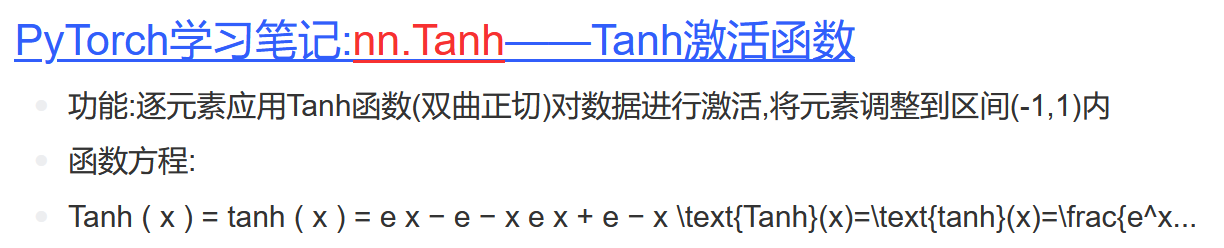

patchGAN则是输出是NxN的矩阵X,每一个元素x[i][j]表示一个patch,对应于图像的一个感受野,最后取各个patch部位的均值来表示最后总的来看是真实图片的概率

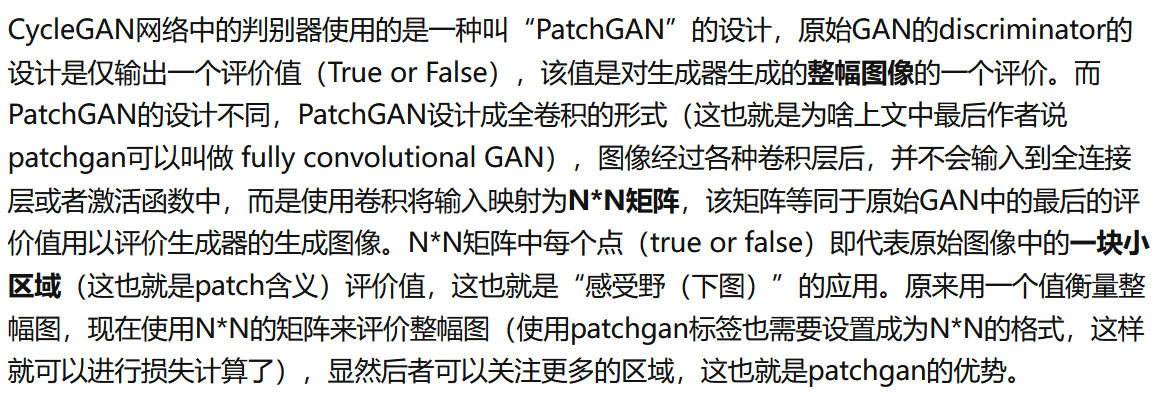

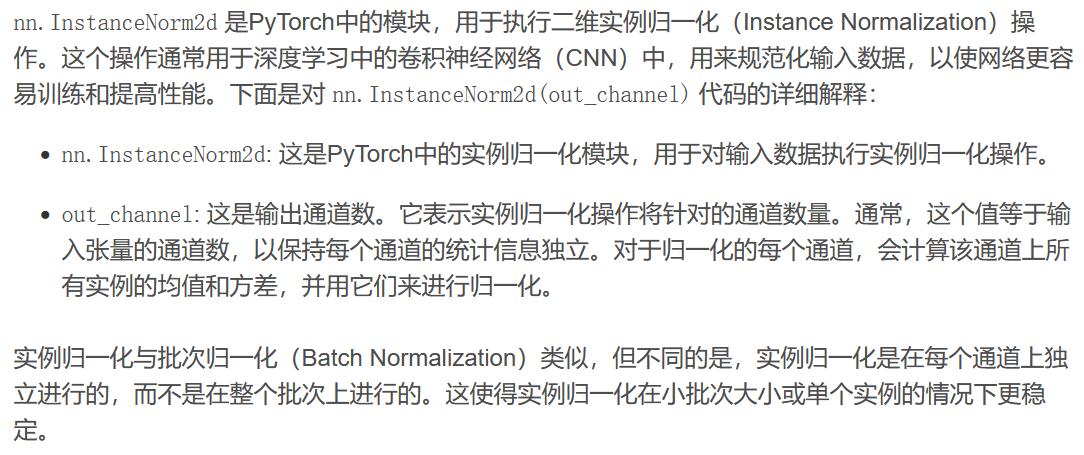

什么是nn.leakyrelu?

在深度学习中，nn.leakyrelu是一种激活函数，它可以用于增强神经网络的非线性特征提取能力。在人工神经网络的每一层中，需要选择一个激活函数。激活函数将输入值进行一个非线性转换，使神经网络能够更好地适应非线性数据。

相对于其他激活函数，如ReLU（Rectified Linear Units）和Sigmoid，nn.leakyrelu具有更好的性能和稳定性。nn.leakyrelu通过引入一个小的负斜率（默认为0.01），解决了ReLU中出现的神经元死亡问题。神经元死亡是指在训练过程中，某些神经元的输出一直为零，导致这些神经元不再参与后续计算，从而影响整个网络的性能。

In [ ]:
##############################
#        Discriminator
##############################
class Discriminator(nn.Module):
    def __init__(self, input_shape):                                        
        super(Discriminator, self).__init__()

        channels, height, width = input_shape                                       ## input_shape:(3， 256， 256)

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)                  ## output_shape = (1, 16, 16)

        def discriminator_block(in_filters, out_filters, normalize=True):           ## 鉴别器块儿
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]   ## layer += [conv + norm + relu]    
            if normalize:                                                           ## 每次卷积尺寸会缩小一半，共卷积了4次
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(                                                 
            *discriminator_block(channels, 64, normalize=False),        ## layer += [conv(3, 64) + relu]
            *discriminator_block(64, 128),                              ## layer += [conv(64, 128) + norm + relu]
            *discriminator_block(128, 256),                             ## layer += [conv(128, 256) + norm + relu]
            *discriminator_block(256, 512),                             ## layer += [conv(256, 512) + norm + relu]
            nn.ZeroPad2d((1, 0, 1, 0)),                                 ## layer += [pad]
            nn.Conv2d(512, 1, 4, padding=1)                             ## layer += [conv(512, 1)]
        )

    def forward(self, img):             ## 输入(1, 3, 256, 256)    
        return self.model(img)          ## 输出(1, 1, 16, 16)

#########################################################################
############################  utils.py  ###################################

## 先前生成的样本的缓冲区
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):                       ## 放入一张图像，再从buffer里取一张出来
        to_return = []                                  ## 确保数据的随机性，判断真假图片的鉴别器识别率
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:          ## 最多放入50张，没满就一直添加
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:          ## 满了就1/2的概率从buffer里取，或者就用当前的输入图片
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


## 设置学习率为初始学习率乘以给定lr_lambda函数的值
class LambdaLR:                                
    def __init__(self, n_epochs, offset, decay_start_epoch):                                                ## (n_epochs = 50, offset = epoch, decay_start_epoch = 30)
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"     ## 断言，要让n_epochs > decay_start_epoch 才可以
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):                                              ## return    1-max(0, epoch - 30) / (50 - 30)
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

In [ ]:
###########################################################################
############################  cycle_gan.py  ###################################

## 超参数配置
parser = argparse.ArgumentParser()
parser.add_argument("--epoch", type=int, default=0, help="epoch to start training from")
parser.add_argument("--n_epochs", type=int, default=5, help="number of epochs of training")
parser.add_argument("--dataset_name", type=str, default="dataset/facades", help="name of the dataset")## ../input/facades-dataset
parser.add_argument("--batch_size", type=int, default=1, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0003, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--decay_epoch", type=int, default=3, help="epoch from which to start lr decay")
parser.add_argument("--n_cpu", type=int, default=2, help="number of cpu threads to use during batch generation")
parser.add_argument("--img_height", type=int, default=256, help="size of image height")
parser.add_argument("--img_width", type=int, default=256, help="size of image width")
parser.add_argument("--channels", type=int, default=3, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=100, help="interval between saving generator outputs")
parser.add_argument("--checkpoint_interval", type=int, default=-1, help="interval between saving model checkpoints")
parser.add_argument("--n_residual_blocks", type=int, default=9, help="number of residual blocks in generator")
parser.add_argument("--lambda_cyc", type=float, default=10.0, help="cycle loss weight")
parser.add_argument("--lambda_id", type=float, default=5.0, help="identity loss weight")
# opt = parser.parse_args()
opt = parser.parse_args(args=[])                 ## 在colab中运行时，换为此行
print(opt)

In [ ]:
## 创建文件夹
os.makedirs("images/%s" % opt.dataset_name, exist_ok=True)
os.makedirs("save/%s" % opt.dataset_name, exist_ok=True)

## input_shape:(3, 256, 256)
input_shape = (opt.channels, opt.img_height, opt.img_width)         

## 创建生成器，判别器对象
G_AB = GeneratorResNet(input_shape, opt.n_residual_blocks)
G_BA = GeneratorResNet(input_shape, opt.n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

## 损失函数
## MES 二分类的交叉熵
## L1loss 相比于L2 Loss保边缘
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

## 如果有显卡，都在cuda模式中运行
if torch.cuda.is_available():
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

## 如果epoch == 0，初始化模型参数; 如果epoch == n, 载入训练到第n轮的预训练模型
if opt.epoch != 0:
    # 载入训练到第n轮的预训练模型
    G_AB.load_state_dict(torch.load("save/%s/G_AB_%d.pth" % (opt.dataset_name, opt.epoch)))
    G_BA.load_state_dict(torch.load("save/%s/G_BA_%d.pth" % (opt.dataset_name, opt.epoch)))
    D_A.load_state_dict(torch.load("save/%s/D_A_%d.pth" % (opt.dataset_name, opt.epoch)))
    D_B.load_state_dict(torch.load("save/%s/D_B_%d.pth" % (opt.dataset_name, opt.epoch)))
else:
    # 初始化模型参数
    G_AB.apply(weights_init_normal)
    G_BA.apply(weights_init_normal)
    D_A.apply(weights_init_normal)
    D_B.apply(weights_init_normal)


## 定义优化函数,优化函数的学习率为0.0003
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=opt.lr, betas=(opt.b1, opt.b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

## 学习率更行进程
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
)

## 先前生成的样本的缓冲区
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()


## 图像 transformations
transforms_ = [
    transforms.Resize(int(opt.img_height * 1.12)),   ## 图片放大1.12倍
    transforms.RandomCrop((opt.img_height, opt.img_width)),         ## 随机裁剪成原来的大小
    transforms.RandomHorizontalFlip(),                              ## 随机水平翻转
    transforms.ToTensor(),                                          ## 变为Tensor数据
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),         ## 正则化
]

In [ ]:
picpath="/kaggle/input/facades"
# "dataset/facades"

In [ ]:
## Training data loader 
train_dataloader = DataLoader(        ## 改成自己存放文件的目录
    ImageDataset(picpath, transforms_=transforms_, unaligned=True),  ## "./datasets/facades" , unaligned:设置非对其数据
    batch_size=opt.batch_size,                                                                  ## batch_size = 1
    shuffle=True,
    num_workers=opt.n_cpu,
)
## Test data loader
val_dataloader = DataLoader(
    ImageDataset(picpath, transforms_=transforms_, unaligned=True, mode="test"), ## "./datasets/facades"
    batch_size=5,
    shuffle=True,
    num_workers=1,
)


## 每间隔100次打印图片
def sample_images(batches_done):      ## （100/200/300/400...）
    """保存测试集中生成的样本"""
    imgs = next(iter(val_dataloader))      ## 取一张图像 
    G_AB.eval()
    G_BA.eval()
    real_A = Variable(imgs["A"]).cuda()    ## 取一张真A
    fake_B = G_AB(real_A)                  ## 用真A生成假B
    real_B = Variable(imgs["B"]).cuda()    ## 去一张真B
    fake_A = G_BA(real_B)                  ## 用真B生成假A
    # Arange images along x-axis
    ## make_grid():用于把几个图像按照网格排列的方式绘制出来
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    ## 把以上图像都拼接起来，保存为一张大图片
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    save_image(image_grid, "images/%s/%s.png" % (opt.dataset_name, batches_done), normalize=False)

In [ ]:
def train():
    # ----------
    #  Training
    # ----------
    prev_time = time.time()                             ## 开始时间
    for epoch in range(opt.epoch, opt.n_epochs):        ## for epoch in (0, 50)
        for i, batch in enumerate(train_dataloader):          ## batch is a dict, batch['A']:(1, 3, 256, 256), batch['B']:(1, 3, 256, 256)
    #       print('here is %d' % i)
            ## 读取数据集中的真图片
            ## 将tensor变成Variable放入计算图中，tensor变成variable之后才能进行反向传播求梯度
            real_A = Variable(batch["A"]).cuda()  ## 真图像A
            real_B = Variable(batch["B"]).cuda()  ## 真图像B

            ## 全真，全假的标签
            valid = Variable(torch.ones((real_A.size(0), *D_A.output_shape)), requires_grad=False).cuda()     ## 定义真实的图片label为1 ones((1, 1, 16, 16))
            fake = Variable(torch.zeros((real_A.size(0), *D_A.output_shape)), requires_grad=False).cuda()     ## 定义假的图片的label为0 zeros((1, 1, 16, 16))
            
            
            ## -----------------
            ##  Train Generator
            ## 原理：目的是希望生成的假的图片被判别器判断为真的图片，
            ## 在此过程中，将判别器固定，将假的图片传入判别器的结果与真实的label对应，
            ## 反向传播更新的参数是生成网络里面的参数，
            ## 这样可以通过更新生成网络里面的参数，来训练网络，使得生成的图片让判别器以为是真的, 这样就达到了对抗的目的
            ## -----------------
            G_AB.train()
            G_BA.train()

            ## Identity loss                                              ## A风格的图像 放在 B -> A 生成器中，生成的图像也要是 A风格
            loss_id_A = criterion_identity(G_BA(real_A), real_A)          ## loss_id_A就是把图像A1放入 B2A 的生成器中，那当然生成图像A2的风格也得是A风格, 要让A1,A2的差距很小 
            loss_id_B = criterion_identity(G_AB(real_B), real_B)

            loss_identity = (loss_id_A + loss_id_B) / 2                   ## Identity loss 

            ## GAN loss
            fake_B = G_AB(real_A)                                         ## 用真图像A生成的假图像B
            loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)               ## 用B鉴别器鉴别假图像B，训练生成器的目的就是要让鉴别器以为假的是真的，假的太接近真的让鉴别器分辨不出来
            fake_A = G_BA(real_B)                                         ## 用真图像B生成的假图像A
            loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)               ## 用A鉴别器鉴别假图像A，训练生成器的目的就是要让鉴别器以为假的是真的,假的太接近真的让鉴别器分辨不出来

            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2                    ## GAN loss

            # Cycle loss 循环一致性损失                                                 
            recov_A = G_BA(fake_B)                                        ## 之前中realA 通过 A -> B 生成的假图像B，再经过 B -> A ，使得fakeB 得到的循环图像recovA， 
            loss_cycle_A = criterion_cycle(recov_A, real_A)               ## realA和recovA的差距应该很小，以保证A,B间不仅风格有所变化，而且图片对应的的细节也可以保留
            recov_B = G_AB(fake_A)
            loss_cycle_B = criterion_cycle(recov_B, real_B)

            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            # Total loss                                                  ## 就是上面所有的损失都加起来
            loss_G = loss_GAN + opt.lambda_cyc * loss_cycle + opt.lambda_id * loss_identity
            optimizer_G.zero_grad()                                       ## 在反向传播之前，先将梯度归0
            loss_G.backward()                                             ## 将误差反向传播
            optimizer_G.step()                                            ## 更新参数
          
            
            ## -----------------------
            ## Train Discriminator A
            ## 分为两部分：1、真的图像判别为真；2、假的图像判别为假
            ## -----------------------
            ## 真的图像判别为真
            loss_real = criterion_GAN(D_A(real_A), valid)
            ## 假的图像判别为假(从之前的buffer缓存中随机取一张)
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)
            loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
            # Total loss
            loss_D_A = (loss_real + loss_fake) / 2
            optimizer_D_A.zero_grad()                                     ## 在反向传播之前，先将梯度归0
            loss_D_A.backward()                                           ## 将误差反向传播
            optimizer_D_A.step()                                          ## 更新参数
            
            ## -----------------------
            ## Train Discriminator B
            ## 分为两部分：1、真的图像判别为真；2、假的图像判别为假
            ## -----------------------
            # 真的图像判别为真
            loss_real = criterion_GAN(D_B(real_B), valid)                
            ## 假的图像判别为假(从之前的buffer缓存中随机取一张)
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
            # Total loss
            loss_D_B = (loss_real + loss_fake) / 2
            optimizer_D_B.zero_grad()                                     ## 在反向传播之前，先将梯度归0
            loss_D_B.backward()                                           ## 将误差反向传播
            optimizer_D_B.step()                                          ## 更新参数
            loss_D = (loss_D_A + loss_D_B) / 2
            
            
            ## ----------------------
            ##  打印日志Log Progress
            ## ----------------------

            ## 确定剩下的大约时间  假设当前 epoch = 5， i = 100
            batches_done = epoch * len(train_dataloader) + i                                        ## 已经训练了多长时间 5 * 400 + 100 次
            batches_left = opt.n_epochs * len(train_dataloader) - batches_done                      ## 还剩下 50 * 400 - 2100 次
            time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))  ## 还需要的时间 time_left = 剩下的次数 * 每次的时间
            prev_time = time.time()
            # Print log
            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
                % (
                    epoch,
                    opt.n_epochs,
                    i,
                    len(train_dataloader),
                    loss_D.item(),
                    loss_G.item(),
                    loss_GAN.item(),
                    loss_cycle.item(),
                    loss_identity.item(),
                    time_left,
                )
            )
            # 每训练100张就保存一组测试集中的图片
            if batches_done % opt.sample_interval == 0:
                sample_images(batches_done)

        # 更新学习率
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()

        
    ## 训练结束后，保存模型
    torch.save(G_AB.state_dict(), "save/%s/G_AB_%d.pth" % (opt.dataset_name, epoch))
    torch.save(G_BA.state_dict(), "save/%s/G_BA_%d.pth" % (opt.dataset_name, epoch))
    torch.save(D_A.state_dict(), "save/%s/D_A_%d.pth" % (opt.dataset_name, epoch))
    torch.save(D_B.state_dict(), "save/%s/D_B_%d.pth" % (opt.dataset_name, epoch))
    print("\nsave my model finished !!")
    #    ## 每间隔几个epoch保存一次模型
    #     if opt.checkpoint_interval != -1 and epoch % opt.checkpoint_interval == 0:
    #         # Save model checkpoints
    #         torch.save(G_AB.state_dict(), "saved_models/%s/G_AB_%d.pth" % (opt.dataset_name, epoch))
    #         torch.save(G_BA.state_dict(), "saved_models/%s/G_BA_%d.pth" % (opt.dataset_name, epoch))
    #         torch.save(D_A.state_dict(), "saved_models/%s/D_A_%d.pth" % (opt.dataset_name, epoch))
    #         torch.save(D_B.state_dict(), "saved_models/%s/D_B_%d.pth" % (opt.dataset_name, epoch))

<!-- train_dataloader = DataLoader(        ## 改成自己存放文件的目录
    ImageDataset(picpath, transforms_=transforms_, unaligned=True),  ## "./datasets/facades" , unaligned:设置非对其数据
    batch_size=opt.batch_size,                                                                  ## batch_size = 1
    shuffle=True,
    num_workers=opt.n_cpu,
) -->

In [ ]:
def test(picpath_test="/kaggle/input/facades/trainA",numjump=8):
    ## 超参数设置
    parser = argparse.ArgumentParser()
    parser.add_argument('--batchSize', type=int, default=2, help='size of the batches')
    parser.add_argument('--dataroot', type=str, default='dataset/facades', help='root directory of the dataset')
    parser.add_argument('--channels', type=int, default=3, help='number of channels of input data')
    parser.add_argument('--n_residual_blocks', type=int, default=9, help='number of channels of output data')
    parser.add_argument('--size', type=int, default=256, help='size of the data (squared assumed)')
    parser.add_argument('--cuda', type=bool, default=True, help='use GPU computation')
    parser.add_argument('--n_cpu', type=int, default=8, help='number of cpu threads to use during batch generation')
    parser.add_argument('--generator_A2B', type=str, default='save/dataset/facades/G_AB_4.pth', help='A2B generator checkpoint file')
    parser.add_argument('--generator_B2A', type=str, default='save/dataset/facades/G_BA_4.pth', help='B2A generator checkpoint file')
#     opt = parser.parse_args()
    opt = parser.parse_args(args=[]) 
    print(opt)

    #################################
    ##          test准备工作        ##
    #################################

    ## input_shape:(3, 256, 256)
    input_shape = (opt.channels, opt.size, opt.size) 
    ## 创建生成器，判别器对象
    netG_A2B = GeneratorResNet(input_shape, opt.n_residual_blocks)
    netG_B2A = GeneratorResNet(input_shape, opt.n_residual_blocks)

    ## 使用cuda
    if opt.cuda:
        netG_A2B.cuda()
        netG_B2A.cuda()

    ## 载入训练模型参数
    netG_A2B.load_state_dict(torch.load(opt.generator_A2B))
    netG_B2A.load_state_dict(torch.load(opt.generator_B2A))

    ## 设置为测试模式
    netG_A2B.eval()
    netG_B2A.eval()

    ## 创建一个tensor数组
    Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
    input_A = Tensor(opt.batchSize, opt.channels, opt.size, opt.size)
    input_B = Tensor(opt.batchSize, opt.channels, opt.size, opt.size)


    '''构建测试数据集'''
    transforms_ = [ transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
#     print("opt.dataroot::",opt.dataroot,"picpath:",picpath)
    
    print(picpath_test)
    test_dataloader = DataLoader(ImageDataset(picpath_test, transforms_=transforms_, mode='test'), 
                            batch_size=opt.batchSize, shuffle=False, num_workers=opt.n_cpu)
#     test_dataloader = DataLoader(ImageDataset(opt.dataroot, transforms_=transforms_, mode='test'), 
#                             batch_size=opt.batchSize, shuffle=False, num_workers=opt.n_cpu)

    print(test_dataloader,len(test_dataloader))

    #################################
    ##           test开始          ##
    #################################

    '''如果文件路径不存在, 则创建一个 (存放测试输出的图片)'''
    if not os.path.exists('output/A'):
        os.makedirs('output/A')
    if not os.path.exists('output/B'):
        os.makedirs('output/B')

    for i, batch in enumerate(test_dataloader):
        print("i:",i)
        ## 输入数据 real
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))
        ## 通过生成器生成的 fake
        fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
        fake_A = 0.5*(netG_B2A(real_B).data + 1.0)
        ## 保存图片
        save_image(fake_A, 'output/A/%04d.png' % (i+1))
        save_image(fake_B, 'output/B/%04d.png' % (i+1))
        print('processing (%04d)-th image...' % (i))
        
        if i>=numjump:break
    print("测试完成")

In [ ]:
train()  ## 训练
# test()   ## 测试

In [ ]:
picpath_test="/kaggle/input/facades"
test(picpath_test,8)   ## 测试

In [ ]:
# ## Training data loader 
# train_dataloader = DataLoader(        ## 改成自己存放文件的目录
#     ImageDataset(picpath, transforms_=transforms_, unaligned=True),  ## "./datasets/facades" , unaligned:设置非对其数据
#     batch_size=opt.batch_size,                                                                  ## batch_size = 1
#     shuffle=True,
#     num_workers=opt.n_cpu,
# )